# 1. Introduction

Team Names : Predictix

Batch : FTDS-BSD-007

Problem Statement : Customer churn is one of the most important factors in retail and other businesses, especially when considering profitability. Increased customer churn can lead to a decline in profits. To mitigate this, we can develop a classification model to predict whether a customer is likely to churn. This model can then provide valuable insights and potential solutions to retain customers at risk of churning.

# 2. Import Library

In [1]:
pip install phik

In [2]:
pip install feature_engine

In [3]:
import pandas as pd
import numpy as np
import warnings
import pickle
warnings.filterwarnings('ignore')
import sklearn
from sklearn.impute import SimpleImputer
from phik import phik_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from feature_engine.outliers import Winsorizer
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import  GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import  classification_report, confusion_matrix

# 3. Data Loading


In [4]:
data = pd.read_csv('/content/florist_customer_churn_raw_fix_cleaned.csv')
data.head(5)

,customer_id,churn,tenure,monthly_charges,total_charges,contract,payment_method,feedback,sentiment,topic
0,CUST001,True,12,3000000.0,36000000.0,one year,credit card,Love the variety of flowers!,positive,bouquet preferences
1,CUST002,True,4,3505000.0,14200000.0,month-to-month,electronic check,Delivery was often late,negative,delivery issues
2,CUST003,False,20,29990000.0,59908000.0,two year,bank transfer,Great service and quality,positive,general feedback
3,CUST004,True,2,3200000.0,6400000.0,month-to-month,mailed check,Not enough variety,negative,bouquet preferences
4,CUST005,True,15,2805000.0,42705000.0,one year,credit card,Beautiful arrangements every time,positive,general feedback


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   customer_id      1000 non-null   object 
 1   churn            1000 non-null   bool   
 2   tenure           1000 non-null   int64  
 3   monthly_charges  1000 non-null   float64
 4   total_charges    1000 non-null   float64
 5   contract         1000 non-null   object 
 6   payment_method   1000 non-null   object 
 7   feedback         1000 non-null   object 
 8   sentiment        1000 non-null   object 
 9   topic            1000 non-null   object 
dtypes: bool(1), float64(2), int64(1), object(6)
memory usage: 71.4+ KB


In [6]:
# See is data has a duplicate data
data.duplicated().sum()

0

Data has no duplicate.

In [7]:
# See is data has a missing value
data.isnull().sum()

,0
customer_id,0
churn,0
tenure,0
monthly_charges,0
total_charges,0
contract,0
payment_method,0
feedback,0
sentiment,0
topic,0


Data has no missing value.

In [8]:
# Know data type
numerical = ['monthly_charges','tenure','total_charges']
unique = ['customer_id','feedback']
categorical = ['contract', 'sentiment', 'topic']
target = ['churn']

# 4. Feature Engineering

## 4.1. Feature Selection

See corelation between every feature to target (churn)

In [9]:
phik_overview = data[numerical + categorical + target].phik_matrix()
phik_overview

interval columns not set, guessing: ['monthly_charges', 'tenure', 'total_charges']


,monthly_charges,tenure,total_charges,contract,sentiment,topic,churn
monthly_charges,1.000000,0.398329,0.471629,0.189315,0.291844,0.391209,0.339607
tenure,0.398329,1.000000,0.965126,0.808046,0.955717,0.550226,0.965793
total_charges,0.471629,0.965126,1.000000,0.742758,0.886993,0.487608,0.890848
contract,0.189315,0.808046,0.742758,1.000000,0.563471,0.629168,0.584262
sentiment,0.291844,0.955717,0.886993,0.563471,1.000000,0.734249,0.877638
topic,0.391209,0.550226,0.487608,0.629168,0.734249,1.000000,0.752073
churn,0.339607,0.965793,0.890848,0.584262,0.877638,0.752073,1.000000


We add treshold 30% correlation to target, so we can drop payment_method from data.

## 4.2. Split data

In [10]:
# Split data and target
X = data.drop(columns=['churn', 'payment_method'])
y = data['churn']

In [11]:
# Split train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 4.3. Check cardinality


In [12]:
# Check cardinality for categorical data
for column in categorical:
    print(column, X_train[column].nunique())

contract 3
sentiment 2
topic 8


In [13]:
data['payment_method'].unique()

array(['credit card', 'electronic check', 'bank transfer', 'mailed check'],
      dtype=object)

In [14]:
# Check cardinality for unique data
for column in unique:
    print(column, X_train[column].nunique())

customer_id 800
feedback 254


Because unique data has a lot cardinality, so were not gonna use unique data.

## 4.4. Check apakah data outlier


In [15]:
# Check outlier from numerical data
data_extreme = []
data_skew = []
data_normal = []

def cek_skew(data):
    for column in numerical:
        if data[column].skew() >= 1 or data[column].skew() <= -1:
            data_extreme.append(column)
        elif data[column].skew() >= 0.5 or data[column].skew() <= -0.5:
            data_skew.append(column)
        else:
            data_normal.append(column)
    print('Data extreme = ', data_extreme)
    print('Data skew = ', data_skew)
    print('Data normal = ', data_normal)

cek_skew(X_train)

Data extreme =  ['monthly_charges']
Data skew =  []
Data normal =  ['tenure', 'total_charges']


Apply capping to numeric data, so that the data is not too skewed.

In [16]:
normal_cap = Winsorizer(capping_method='gaussian',
                        fold = 3,
                        tail = 'both',
                        variables = data_normal)
extreme_cap = Winsorizer(capping_method='iqr',
                         fold=3,
                         tail = 'both',
                         variables = data_extreme)

## 4.5. Data Scaling

Apply data scaling for numerical data.

In [17]:
num_normal_scale = Pipeline([
    ('winsorizer', normal_cap),
    ('scaler', StandardScaler())
])

num_skew_scale = Pipeline([
    ('winsorizer', extreme_cap),
    ('robust', RobustScaler())
])

## 4.6. Data Encoding

Apply encode for every categorical data.

In [18]:
Nominal_encoding = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),  # impute missing values with the most frequent category
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [19]:

preprocessor = ColumnTransformer(
    transformers=[
        ('cat_nominal', Nominal_encoding, categorical)
        ,('num_skew', num_skew_scale,data_extreme)
        ,('num_normal',num_normal_scale, data_normal)

    ], remainder='drop')

# 5. Before Tune Model

## 5.1. Cross Validation for see the best model


Use Cross Validation for seek model with the best accuration between :

1. XGBClassifier The XGBClassifier is a supervised learning model from the XGBoost library. It's an implementation of the Extreme Gradient Boosting algorithm, which is a popular and powerful ensemble method for classification tasks. XGBoost is known for its speed, scalability, and accuracy.

2. RandomForestClassifier The RandomForestClassifier is a supervised learning model from scikit-learn's ensemble module. It's an ensemble method that combines multiple decision trees to improve the accuracy and robustness of predictions. Random forests are effective in handling high-dimensional data and can handle both categorical and numerical features.

3. LogisticRegression The LogisticRegression model is a linear model from scikit-learn's linear_model module. It's a widely used algorithm for binary classification problems, where the goal is to predict a probability of an event occurring (e.g., 0 or 1, yes or no). Logistic regression is simple to implement and interpret, but may not perform well with complex, non-linear relationships.

4. SVC (Support Vector Classifier) The SVC model is a supervised learning model from scikit-learn's svm module. It's an implementation of the Support Vector Machine algorithm, which aims to find a hyperplane that maximally separates classes in the feature space. SVC is effective in handling high-dimensional data and can be used for both classification and regression tasks.

5. KNeighborsClassifier The KNeighborsClassifier model is a supervised learning model from scikit-learn's neighbors module. It's an implementation of the k-Nearest Neighbors algorithm, which predicts the class label of a new instance based on the majority vote of its k nearest neighbors. KNN is a simple, non-parametric method that can be effective for small to medium-sized datasets.

6. DecisionTreeClassifier The DecisionTreeClassifier model is a supervised learning model from scikit-learn's tree module. It's an implementation of the Decision Tree algorithm, which recursively partitions the feature space to predict class labels. Decision trees are easy to interpret and can handle both categorical and numerical features.

7. GaussianNB (Gaussian Naive Bayes) The GaussianNB model is a supervised learning model from scikit-learn's naive_bayes module. It's an implementation of the Naive Bayes algorithm, which assumes independence between features. GaussianNB is a simple, probabilistic method that can be effective for binary classification problems with continuous features.

In [20]:
# Membuat pipeline untuk setiap model yang akan dibandingkan
pipe_svc = Pipeline([('preprocessor', preprocessor), ('classifier', SVC())])
pipe_dt = Pipeline([('preprocessor', preprocessor),('classifier', DecisionTreeClassifier(random_state=10))])
pipe_rf = Pipeline([('preprocessor', preprocessor), ('classifier', RandomForestClassifier(random_state=10))])
pipe_knn = Pipeline([('preprocessor', preprocessor), ('classifier', KNeighborsClassifier())])
pipe_nb = Pipeline([('preprocessor', preprocessor),('classifier', GaussianNB())])
pipe_xgb = Pipeline([('preprocessor', preprocessor),('classifier', XGBClassifier())])
pipe_lr = Pipeline([('preprocessor', preprocessor),('classifier', LogisticRegression())])

In [21]:
# Menentukan skfold
skfold = StratifiedKFold(n_splits = 5)

In [22]:
# Membuat cross-validation untuk setiap model dan gunakan scoring akurasi
cv_svm_model = cross_val_score(pipe_svc, X_train, y_train, cv=skfold, scoring='recall', n_jobs=-1)
cv_dt_model = cross_val_score(pipe_dt, X_train, y_train, cv=skfold, scoring='recall', n_jobs=-1)
cv_rf_model = cross_val_score(pipe_rf, X_train, y_train, cv=skfold, scoring='recall', n_jobs=-1)
cv_knn_model = cross_val_score(pipe_knn, X_train, y_train, cv=skfold, scoring='recall', n_jobs=-1)
cv_nb_model = cross_val_score(pipe_nb, X_train, y_train, cv=skfold, scoring='recall', n_jobs=-1)
cv_xgb_model = cross_val_score(pipe_xgb, X_train, y_train, cv=skfold, scoring='recall', n_jobs=-1)
cv_lr_model = cross_val_score(pipe_lr, X_train, y_train, cv=skfold, scoring='recall', n_jobs=-1)

In [23]:
# Mencari model dengan hasil scoring akurasi terbaik
name_model = []
cv_scores = 0
for cv, name in zip([cv_svm_model, cv_dt_model, cv_rf_model, cv_knn_model, cv_nb_model, cv_xgb_model, cv_lr_model],
                   ['svm_model', 'dt_model', 'rf_model', 'knn_model', 'nb_model', 'xgb_model', 'logistic_regression_model']):
  print(name)
  print('Recall - All - Cross Validation :', [round(x, 3) for x in cv])
  print('Recall - Mean - Cross Validation :', round(cv.mean(), 3))
  print('Recall - std - Cross Validation :', round(cv.std(), 3))
  print('Recall - Range of Test Set :', round(cv.mean()-cv.std(), 3), '-', round(cv.mean()+cv.std(), 3))
  print('-'*50)
  if cv.mean() > cv_scores:
    cv_scores = cv.mean()
    name_model = name
  else:
    pass
print('Best Model:', name_model)
print('Cross Val Mean from Best Model:', round(cv_scores, 3))

svm_model
Recall - All - Cross Validation : [0.914, 0.962, 0.912, 0.938, 0.912]
Recall - Mean - Cross Validation : 0.928
Recall - std - Cross Validation : 0.02
Recall - Range of Test Set : 0.908 - 0.948
--------------------------------------------------
dt_model
Recall - All - Cross Validation : [0.889, 0.938, 0.888, 0.938, 0.875]
Recall - Mean - Cross Validation : 0.905
Recall - std - Cross Validation : 0.027
Recall - Range of Test Set : 0.879 - 0.932
--------------------------------------------------
rf_model
Recall - All - Cross Validation : [0.901, 0.95, 0.9, 0.938, 0.9]
Recall - Mean - Cross Validation : 0.918
Recall - std - Cross Validation : 0.022
Recall - Range of Test Set : 0.896 - 0.939
--------------------------------------------------
knn_model
Recall - All - Cross Validation : [0.914, 0.95, 0.912, 0.938, 0.912]
Recall - Mean - Cross Validation : 0.925
Recall - std - Cross Validation : 0.016
Recall - Range of Test Set : 0.91 - 0.941
-----------------------------------------

Based from cross validation, svm is the best model among other in cross validation. So model gonna use SVM classifier.

## 5.2. Model Definition

## Support Vector Classifier (SVC)

**SVC** is a supervised machine learning algorithm used for classification tasks. It works by finding a hyperplane in a high-dimensional space that separates data points of different classes. The goal is to find the hyperplane that maximizes the margin between the two classes.

### Key Concepts:
* **Hyperplane:** A decision boundary that separates data points into different classes.
* **Margin:** The distance between the hyperplane and the nearest data points of either class.
* **Support Vectors:** The data points that lie closest to the hyperplane and define the margin.

### How SVC Works:
1. **Feature Engineering:** The data is prepared with appropriate features that can help in classification.
2. **Kernel Trick:** In cases where the data is not linearly separable in the original space, the kernel trick is used to map the data into a higher-dimensional space where it might become linearly separable.
3. **Hyperplane Optimization:** The algorithm finds the optimal hyperplane that maximizes the margin between the classes.
4. **Classification:** New data points are classified based on their position relative to the hyperplane.

### Advantages of SVC:
* **Effective with small datasets:** SVC can perform well even with limited data.
* **Handles non-linearity:** The kernel trick allows SVC to handle non-linearly separable data.
* **High generalization performance:** SVC often achieves good performance on unseen data.

### Disadvantages of SVC:
* **Computational complexity:** Training SVC can be computationally expensive for large datasets.
* **Sensitivity to outliers:** Outliers can significantly affect the hyperplane and classification results.
* **Choice of kernel:** Selecting the appropriate kernel function can be challenging.

### Common Kernel Functions:
* **Linear kernel:** Suitable for linearly separable data.
* **Polynomial kernel:** Can capture non-linear relationships between features.
* **Radial Basis Function (RBF) kernel:** A popular choice for non-linear relationships, but requires careful tuning of the gamma parameter.

### Applications of SVC:
* **Image classification:** Recognizing objects or scenes in images.
* **Text classification:** Categorizing text documents into different categories.
* **Bioinformatics:** Predicting protein structures or functions.
* **Financial forecasting:** Predicting stock prices or market trends.

**In conclusion,** SVC is a powerful classification algorithm that can effectively handle both linear and non-linear data. By understanding its key concepts and advantages, you can leverage SVC for various classification tasks in different domains.


## 5.3. Model Training

In [24]:
model = SVC()

In [25]:
clf = Pipeline([('preprocessor', preprocessor), ('classifier', model)])
clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat_nominal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['contract', 'sentiment',
                                                   'topic']),
                                                 ('num_skew',
                                                  Pipeline(steps=[('winsorizer',
                                                                   Winsorizer(capping_method='iqr',
                                                                              fold=3,
                                                                              tail='both',
                                                                              variables=['monthly_charges'])),
                                                                  ('robust',
                                                                   RobustScaler())]),
                                                  ['monthly_charges']),
                                                 ('num_normal',
                                                  Pipeline(steps=[('winsorizer',
                                                                   Winsorizer(fold=3,
                                                                              tail='both',
                                                                              variables=['tenure',
                                                                                         'total_charges'])),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['tenure',
                                                   'total_charges'])])),
                ('classifier', SVC())])

## 5.4. Model Evaluation

In [26]:
%%time
y_pred_train = clf.predict(X_train)
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

       False       0.93      0.94      0.93       399
        True       0.94      0.93      0.93       401

    accuracy                           0.93       800
   macro avg       0.93      0.93      0.93       800
weighted avg       0.93      0.93      0.93       800

CPU times: user 55 ms, sys: 1.96 ms, total: 57 ms
Wall time: 60.2 ms


In [27]:
%%time
y_pred_test = clf.predict(X_test)
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

       False       0.88      0.92      0.90        92
        True       0.93      0.89      0.91       108

    accuracy                           0.91       200
   macro avg       0.90      0.91      0.90       200
weighted avg       0.91      0.91      0.91       200

CPU times: user 62.2 ms, sys: 2.63 ms, total: 64.9 ms
Wall time: 71.8 ms


Because the case is to predict churn, we can focus on seeking False Negatives, so we can see the recall of true. From the evaluation above, we know that the recall of true is 93% in the training set and 89% in the test set. We're going to use hyperparameter tuning to make it a better fit.

# 6. Hyperparameter Tuning

In [28]:
param_grid = {
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__kernel': ['rbf', 'linear','sigmoid'],
    'classifier__degree': [2, 3, 4, 5],
    'classifier__coef0': [0.0, 0.5, 1.0]
}

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=skfold, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best score found: ", grid_search.best_score_)

best_model = grid_search.best_estimator_

Best parameters found:  {'classifier__C': 0.1, 'classifier__coef0': 0.0, 'classifier__degree': 2, 'classifier__kernel': 'linear'}
Best score found:  0.9324999999999999


## 6.1. Model Evalutaion after hyperparameter tuning.

In [29]:
%%time
y_pred_train = best_model.predict(X_train)
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

       False       0.93      0.94      0.93       399
        True       0.94      0.93      0.93       401

    accuracy                           0.93       800
   macro avg       0.93      0.93      0.93       800
weighted avg       0.93      0.93      0.93       800

CPU times: user 39.3 ms, sys: 0 ns, total: 39.3 ms
Wall time: 41.3 ms


In [30]:
%%time
y_pred_test = best_model.predict(X_test)
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

       False       0.88      0.92      0.90        92
        True       0.93      0.89      0.91       108

    accuracy                           0.91       200
   macro avg       0.90      0.91      0.90       200
weighted avg       0.91      0.91      0.91       200

CPU times: user 28.7 ms, sys: 0 ns, total: 28.7 ms
Wall time: 28.7 ms


Hyperparameter tuning did not lead to an improvement in recall for the training or test data. However, it did result in a faster running time. Predicting on the test data now takes 28.7 milliseconds with hyperparameter tuning, compared to 64.9 milliseconds without it. This represents a 36.2-millisecond improvement.

## 6.2 Identify which classes the model is most likely to misclassify

In [31]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_test)

# Find the indices where the actual value is True and the predicted value is False (False Negatives)
false_negative_indices = np.where((y_test == True) & (y_pred_test == False))

# Get the corresponding rows from X_test
false_negative_instances = X_test.iloc[false_negative_indices]

# Display the characteristics of the misclassified instances
print("Characteristics of False Negatives (Actual: True, Predicted: False):")
print(false_negative_instances.describe())
print(false_negative_instances.head(15))


Characteristics of False Negatives (Actual: True, Predicted: False):
          tenure  monthly_charges  total_charges
count  12.000000     1.200000e+01   1.200000e+01
mean   14.583333     2.828750e+06   4.126792e+07
std     4.358030     1.352796e+05   1.048501e+07
min    10.000000     2.605000e+06   3.050000e+07
25%    11.000000     2.776250e+06   3.130500e+07
50%    13.500000     2.852500e+06   3.950000e+07
75%    17.750000     2.905000e+06   4.945000e+07
max    22.000000     3.005000e+06   5.830000e+07
    customer_id  tenure  monthly_charges  total_charges  contract  \
312     CUST313      13        2900000.0     37700000.0  one year   
820     CUST821      14        2905000.0     41300000.0  two year   
296     CUST297      12        2900000.0     34800000.0  one year   
866     CUST867      20        2705000.0     55000000.0  one year   
292     CUST293      11        2805000.0     31305000.0  one year   
826     CUST827      21        2605000.0     55605000.0  one year   
816    

In [32]:
# Find the indices where the actual value is False and the predicted value is True (False Positives)
false_positive_indices = np.where((y_test == False) & (y_pred_test == True))

# Get the corresponding rows from X_test
false_positive_instances = X_test.iloc[false_positive_indices]

# Display the characteristics of the misclassified instances
print("Characteristics of False Positives (Actual: False, Predicted: True):")
print(false_positive_instances.describe())
print(false_positive_instances.head(10))


Characteristics of False Positives (Actual: False, Predicted: True):
         tenure  monthly_charges  total_charges
count  7.000000     7.000000e+00   7.000000e+00
mean   4.285714     3.073571e+06   1.361500e+07
std    2.690371     1.799008e+05   9.399312e+06
min    2.000000     2.905000e+06   5.900000e+06
25%    2.500000     2.952500e+06   7.450000e+06
50%    3.000000     3.000000e+06   9.000000e+06
75%    5.500000     3.150000e+06   1.725000e+07
max    9.000000     3.405000e+06   3.100500e+07
    customer_id  tenure  monthly_charges  total_charges        contract  \
899     CUST900       2        2905000.0      5900000.0  month-to-month   
883     CUST884       2        2905000.0      5900000.0  month-to-month   
901     CUST902       3        3000000.0      9000000.0  month-to-month   
879     CUST880       4        3200000.0     12800000.0  month-to-month   
39      CUST040       9        3405000.0     31005000.0  month-to-month   
55      CUST056       3        3000000.0      900

The model is capable of detecting anomalous data points within the test dataset. These anomalies exhibit patterns that deviate significantly from the general trends observed in the data and are inconsistent with the patterns learned by the model. The model has been trained to associate high tenure, high total charges, and positive sentiment with a low likelihood of churn. Conversely, low tenure, low total charges, and negative sentiment are typically predicted to indicate churn.

However, we have identified instances where the model's predictions contradict our domain knowledge. For example, some customers with high tenure, high total charges, and positive sentiment were incorrectly classified as churners (false negatives). Additionally, there were cases where customers with low tenure, low total charges, and negative sentiment were predicted to remain loyal (false positives). These discrepancies highlight the limitations of the model in capturing the full complexity of customer churn behavior.

# 7. Model Saving

In [33]:
# Save the model to a file
with open('model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

# 8. Summary

## 8.1. Model Evaluation and Improvement

### Model Overview
This binary classification model is designed to predict whether a customer will churn or not. Given the significance of customer retention, recall is our primary evaluation metric. The model achieved a recall score of 93% on the training data and 89% on the testing data, indicating its ability to accurately identify most customers who actually churn.

### Feature Importance
Feature importance analysis reveals that a combination of `tenure`, `total_charges`, and customer `sentiment` significantly influences churn predictions. Customers with high tenure, total charges, and positive sentiment are more likely to be retained, while those with opposite characteristics are at a higher risk of churn.

### Model Strengths
1. **Strong recall performance:** The model achieved a robust recall score of 89% on the testing data.
2. **Optimized for speed:** Through hyperparameter tuning, the model's performance has been optimized for faster inference compared to the default SVC.
3. **Easy to deploy:** The model is encapsulated within a pipeline, simplifying its deployment and application.

### Model Weaknesses
1. **Overfitting:** The model may be overfitting the training data.
2. **Outliers:** The presence of outliers that deviate from the general patterns can impact model performance.

### Future Improvements
1. **Outlier detection and handling:** Implement techniques to identify and address outliers that may be distorting the model's learning.
2. **Advanced hyperparameter tuning:** Explore more sophisticated hyperparameter tuning methods to further optimize the model.
3. **Data augmentation:** Consider augmenting the dataset to improve model generalization and reduce overfitting.

### Additional Considerations
* **Imbalanced classes:** If the dataset exhibits class imbalance (i.e., more non-churn instances than churn instances), techniques like oversampling, undersampling, or class weighting can be employed.
* **Feature engineering:** Creating new features or transforming existing ones may enhance the model's predictive power.
* **Interpretability:** Investigate methods to improve the model's interpretability, making it easier to understand the underlying decision-making process.

By addressing these areas, we can further enhance the model's performance and reliability in predicting customer churn.

## 8.2. Customer Feedback Analysis From Chrun Customer

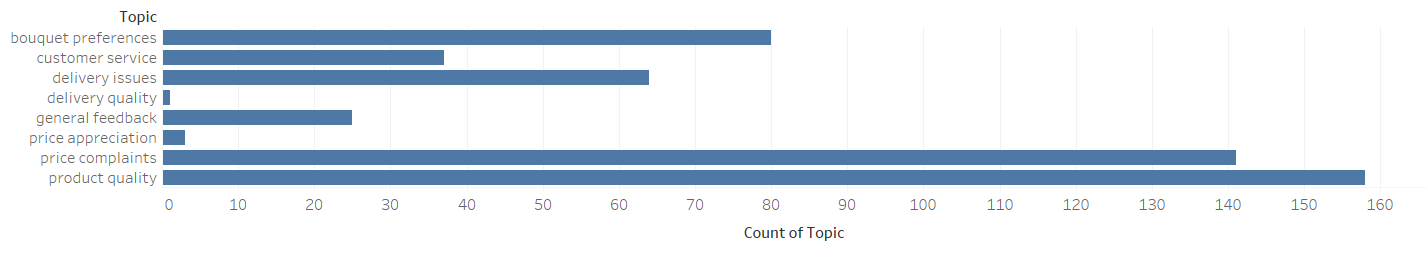

* **Product Quality:** The most frequently discussed topic, indicating a need for focus on product excellence.
* **Pricing:** Price complaints are a recurring concern, suggesting pricing optimization is necessary.
* **Delivery and Customer Service:** These areas also require attention based on customer feedback.

**Marketing Recommendations**

* **Product Focus:** Emphasize product quality and unique features in marketing.
* **Pricing Strategy:** Implement transparent pricing and consider value-added offers.
* **Customer Testimonials:** Showcase positive customer experiences to build trust.

**Customer Service Recommendations**

* **Delivery Improvement:** Prioritize improving delivery efficiency and reliability.
* **Proactive Engagement:** Address customer concerns proactively through effective communication.
* **Representative Training:** Ensure customer service representatives are well-trained in product knowledge and handling complaints.

**Other Division Recommendations**

* **Product Development:** Continuously monitor customer feedback for product improvement.
* **Operations:** Collaborate with customer service and marketing for efficient delivery processes.
* **Finance:** Analyze pricing data to inform pricing decisions and identify cost optimization opportunities.

## 8.3 Strategies to Reduce Customer Churn

### Focus on Personalization and Quality

* **Communication:**
  * **Prompt Follow-up:** Implement a ticketing system to track and respond to all customer complaints within 24 hours.
  * **Personalization:** Utilize customer data to send relevant product recommendations and special offers via email or app notifications.
* **Products and Services:**
  * **Continuous Improvement:** Conduct regular customer satisfaction surveys and use the results to enhance product/service quality.
  * **Shipping:** Collaborate with logistics partners to ensure timely delivery and real-time shipment tracking.
* **Technology:**
  * **Chatbot:** Implement an intelligent chatbot to answer common customer questions 24/7.
  * **Predictive Analytics:** Use analytics tools to identify customer behavior patterns that indicate potential churn and take proactive interventions.

### Enhancing Loyalty

* **Loyalty Programs:**
  * **Points and Rewards:** Award points to customers for every purchase and allow them to redeem for attractive rewards.
  * **Referral Programs:** Provide incentives to customers who refer friends or family.
* **Special Offers:**
  * **Discounts:** Offer exclusive discounts to customers who haven't made a purchase in a while.
  * **Bundling:** Create attractive bundles with more competitive pricing.